In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

import nltk
import string

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

### Load the .csv file with all the data to be clustred

In [2]:
df = pd.read_csv('corpus.csv', nrows=1000)
df.head()

,file_id,text
0,9400,03 LiDCO Annual Report 200809 Technical Innova...
1,8174,Insp Ired Gam In GG roup p LC annua L report ...
2,6855,GREENE KING PLC Annual report 2013 site REVIEW...
3,8388,Invensys plc Annual Report and Accounts 200...
4,10924,NAUTICAL PETROLEUM PLC REPORT AND ACCOUNTS 200...


#### Take just the text column and lower all the text

In [3]:
data = df['text'].str.lower()
data

0      03 lidco annual report 200809 technical innova...
1      insp ired  gam in gg roup p lc annua l report ...
2      greene king plc annual report 2013 site review...
3      invensys plc    annual report and accounts 200...
4      nautical petroleum plc report and accounts 200...
                             ...                        
995    burberry group plc annual report 201112 chief ...
996    chief executive officers review 2012 has been ...
997    design and production by accrue the paper used...
998    strategic report 4 abcam plc annual report and...
999    .04   proof three  250315 what our customers a...
Name: text, Length: 1000, dtype: object

In [22]:
print(data.isna().sum())  # Shows how many empty rows exists
data = data.dropna()  # Drops the row that are empty
print(data.isna().sum())  # Shows how many empty rows exists after dropna

1
0


In [23]:
tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english',#tokenizer = tokenize_and_stem,
                             max_features = 20000)
tf_idf = tf_idf_vectorizor.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

#### Feature names

In [24]:
pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names()).head()

,00,000,00000hillandsmitharbck,0001,000s,001,0011,0025,004,005,...,zircadian,zloty,zn,zoladex,zone,zones,zoo,zoopla,zurich,zygos
0,0.000000,0.150376,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
1,0.004371,0.069226,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
2,0.000000,0.006357,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.002403
3,0.005720,0.000000,0.0,0.0,0.00175,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.001083,0.0,0.0,0.0,0.0,0.000000
4,0.000982,0.081162,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000


## PCA

In [27]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)

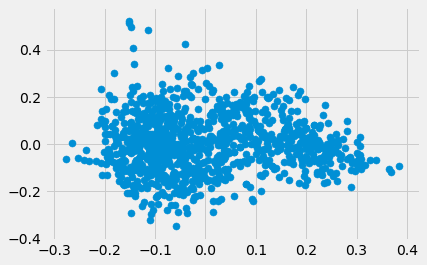

In [29]:
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], s=50, cmap='viridis')

## K- Means

In [42]:
estimater = KMeans(n_clusters = 3)
estimater.fit(Y_sklearn)
predicted_values = estimater.predict(Y_sklearn)

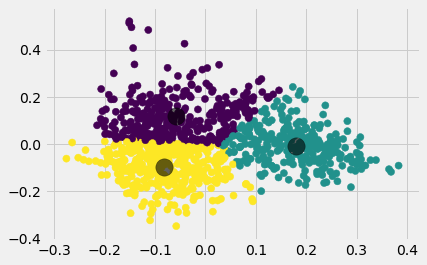

In [51]:
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=50, cmap='viridis')

centers = estimater.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

#### Cluster centers

In [43]:
print(estimater.cluster_centers_)

[[-0.05823176  0.11780669]
 [ 0.1786661  -0.00577715]
 [-0.08138729 -0.09815847]]


## Avg distance to centroid
### Transform the predicted values to values as distance to center of the centroid

In [36]:
res = estimater.transform(Y_sklearn)
res

array([[0.17624456, 0.28411508, 0.04938765],
       [0.23452444, 0.46883559, 0.4394862 ],
       [0.22261421, 0.06454375, 0.21189728],
       ...,
       [0.06101227, 0.323682  , 0.22237654],
       [0.29224051, 0.03310387, 0.30900668],
       [0.22695651, 0.04079547, 0.24530781]])

Each row is values of distances to each centroid

In [44]:
print(f'Shape: {res.shape}')

Shape: (999, 3)


Calculate the avg distance in each row of the np array

In [52]:
avg_distance = np.mean(res, axis=0)
print('Avg distance to centroid:')
print(f'Cluster 1: {avg_distance[0]}')
print(f'Cluster 2: {avg_distance[1]}')
print(f'Cluster 2: {avg_distance[2]}')

Avg distance to centroid:
Cluster 1: 0.2013919317410955
Cluster 2: 0.23085881133661995
Cluster 2: 0.19332710637164574


## Purity

$Purity = \frac 1 N \sum_{i=1}^k max_j | c_i \cap t_j |$
- N - Number of nodes
- K - Number of clusters (in our case K = 3)
- C - Ground truth clusters
- t - Results classification

### Creating ground truth

backup variables

In [116]:
t_predicted_values = predicted_values
ground_truth = Y_sklearn

reshaping for concat

In [117]:
t_predicted_values.shape

t = t_predicted_values.reshape(ground_truth.shape[0], 1)

print(f'Predicted values shape: {t.shape}')

print(f'Y_sklearn shape: {ground_truth.shape}')

Predicted values shape: (999, 1)
Y_sklearn shape: (999, 2)


### Concat the arrays
#### Now we have ground truth classficaiton of the data : (axis, axis, cluster)

In [118]:
ground_truth = np.concatenate((ground_truth, t), axis=1)

In [119]:
pd.DataFrame(ground_truth, columns=['axis1', 'axis2', 'cluster']).head()

,axis1,axis2,cluster
0,-0.101489,-0.053047,2.0
1,-0.140893,0.337281,0.0
2,0.115912,-0.020870,1.0
3,-0.039021,-0.109496,2.0
4,-0.114970,0.148433,0.0


In [141]:
ground_truth[:,2]

x, y = np.unique(ground_truth[:,2], return_counts=True)

x = [int(v) for v in x.tolist()]
total = np.sum(y)
y = [int(v) for v in y.tolist()]
x_y = dict(zip(x, y))
print(f'Total: {total}')

Total: 999


{0: 333, 1: 283, 2: 383}


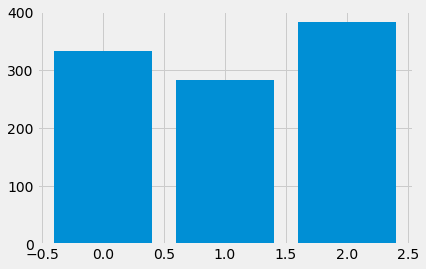

In [142]:
plt.bar(x, y)
print(x_y)